In [27]:
import pickle
import networkx as nx
from cdlib import evaluation
from cdlib.classes import NodeClustering
import pickle
from cdlib import algorithms
from cdlib import viz
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from sklearn.manifold import MDS
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import random
import scipy.spatial as spatial
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import metrics
import scipy.cluster.hierarchy as sch
from sklearn_extra.cluster import KMedoids

In [28]:
GRAPH_FILENAME = "../jpetstore/jpetstore_128scenarios_nopolicies_sobol_graph.pkl"
# GRAPH_FILENAME = "../cargo/cargo_128scenarios_nopolicies_sobol_graph.pkl"
java_graph = None
with open(GRAPH_FILENAME, 'rb') as f:
     java_graph = pickle.load(f)

java_graph.nodes(data=True)
java_graph.edges(data=True)

EdgeDataView([('AccountActionBean.java', 'AbstractActionBean.java', {'weight': 105}), ('AccountActionBean.java', 'Account.java', {'weight': 105}), ('AccountActionBean.java', 'AccountActionBean.java', {'weight': 20}), ('AccountActionBean.java', 'AccountService.java', {'weight': 25}), ('AccountActionBean.java', 'CatalogService.java', {'weight': 15}), ('AccountActionBean.java', 'AccountActionBeanTest.java', {'weight': 175}), ('AccountActionBean.java', 'OrderActionBean.java', {'weight': 20}), ('AbstractActionBean.java', 'AccountActionBeanTest.java', {'weight': 5}), ('AbstractActionBean.java', 'CartActionBean.java', {'weight': 105}), ('AbstractActionBean.java', 'CatalogActionBean.java', {'weight': 105}), ('AbstractActionBean.java', 'CatalogActionBeanTest.java', {'weight': 5}), ('AbstractActionBean.java', 'OrderActionBean.java', {'weight': 125}), ('AbstractActionBean.java', 'OrderActionBeanTest.java', {'weight': 5}), ('Account.java', 'AccountActionBeanTest.java', {'weight': 80}), ('Account.j

In [29]:
PARTITIONS_FILENAME = "../jpetstore/jpetstore_128scenarios_nopolicies_sobol_partitions.pkl"
# PARTITIONS_FILENAME = "../cargo/cargo_128scenarios_nopolicies_sobol_partitions.pkl"
partitions_dict = None
with open(PARTITIONS_FILENAME, 'rb') as f:
     partitions_dict = pickle.load(f)

print("partitions:", len(partitions_dict))

key_0 = list(partitions_dict.keys())[10]
partitions_dict[key_0]

partitions: 1212


{0: ['CartActionBean.java',
  'OrderActionBean.java',
  'AbstractActionBean.java',
  'CatalogActionBean.java',
  'AccountActionBean.java',
  'Order.java',
  'Account.java',
  'AccountService.java',
  'AccountMapper.java',
  'CategoryMapper.java',
  'ItemMapper.java',
  'CatalogService.java',
  'ProductMapper.java',
  'Product.java',
  'CartItem.java',
  'Cart.java',
  'Item.java',
  'LineItem.java',
  'Sequence.java',
  'LineItemMapper.java',
  'OrderMapper.java',
  'OrderService.java',
  'SequenceMapper.java'],
 1: ['Order.java',
  'Account.java',
  'CartActionBean.java',
  'OrderActionBean.java',
  'AbstractActionBean.java',
  'CatalogActionBean.java',
  'AccountActionBean.java',
  'AccountService.java',
  'AccountMapper.java',
  'CategoryMapper.java',
  'ItemMapper.java',
  'CatalogService.java',
  'ProductMapper.java',
  'Product.java',
  'CartItem.java',
  'Cart.java',
  'Item.java',
  'LineItem.java',
  'Sequence.java',
  'LineItemMapper.java',
  'OrderMapper.java',
  'OrderServi

In [30]:
key_0 = list(partitions_dict.keys())[11]
n_partitions = list(partitions_dict[key_0].values())
print(len(n_partitions), "partitions")
n_clustering = NodeClustering(communities=n_partitions, graph=java_graph, overlap=True)

9 partitions


In [31]:
# Omega index indicates the similarity between two partitions
# If omega = 1, the two partitions are identical (distance = 0), and omega = 0 (distance = 1) is the opposite case
# Thus, omega works as a similarity index
def compute_omega_index(partition_i, partition_j, graph, distance=False):
    clustering_i = NodeClustering(communities=list(partition_i.values()), graph=graph, overlap=True)
    clustering_j = NodeClustering(communities=list(partition_j.values()), graph=graph, overlap=True)
    if distance:
        return 1 - evaluation.omega(clustering_i, clustering_j).score
    else:
        return evaluation.omega(clustering_i, clustering_j).score

def get_noise_classes(partition, graph):
    reference_class_set = set(list(graph.nodes()))
    partition_class_set = set([x for xs in partition.values() for x in xs])
    difference_set = reference_class_set.difference(partition_class_set)
    return difference_set

def update_partition_with_noise(partition, graph):
    noise_classes = get_noise_classes(partition, graph)
    if len(noise_classes) > 0:
        partition[-1] = list(noise_classes) # -1 is the key for the noise classes

    return partition

# Checking the number of classes of the whole project, versus the classes assigned to the partitions
reference_class_set = set(list(java_graph.nodes()))
print("Reference class set:", len(reference_class_set), 'classes')
lenght_noise_classes = set()
for k in partitions_dict.keys():
    n_noise = len(get_noise_classes(partitions_dict[k], java_graph))
    lenght_noise_classes.add(n_noise)
if len(lenght_noise_classes) == 1:
    print("All the partitions have the same noise classes", lenght_noise_classes)
else:
    print("Warning: The partitions have different numbers of noise classes!", min(lenght_noise_classes), max(lenght_noise_classes))

Reference class set: 41 classes
All the partitions have the same noise classes {17}


9


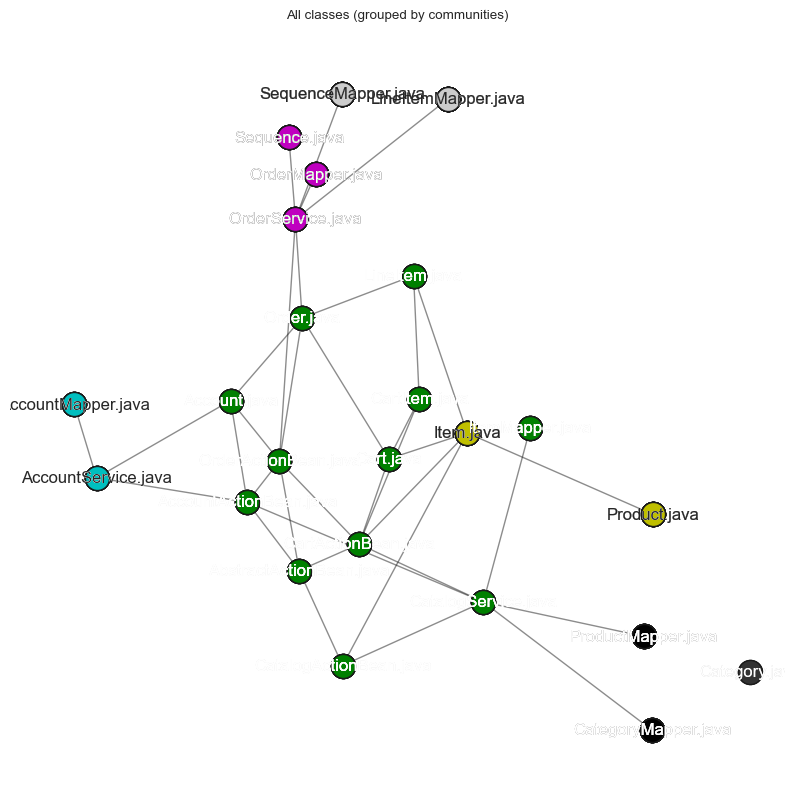

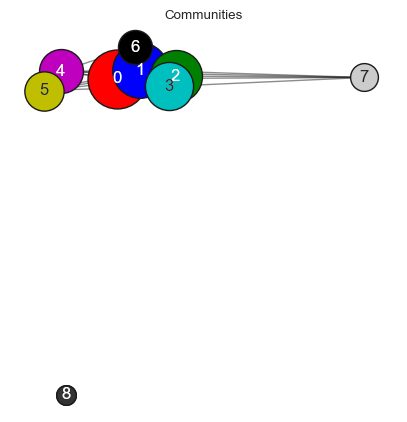

In [32]:

g = java_graph
lp_coms = n_clustering
print(len(lp_coms.communities))

pos = nx.fruchterman_reingold_layout(g)
viz.plot_network_clusters(g, lp_coms, pos, figsize=(10, 10), plot_overlaps=False, plot_labels=True, node_size=300)
plt.title("All classes (grouped by communities)")
plt.show()

viz.plot_community_graph(g, lp_coms, figsize=(5, 5), plot_overlaps=True, plot_labels=True)
plt.title("Communities")
plt.show()

In [33]:
SIMILARITY_FILENAME = "../jpetstore/jpetstore_omega_scores.csv"
# SIMILARITY_FILENAME = "../jpetstore/jpetstore_omega_scores_noise.csv"
# SIMILARITY_FILENAME = "../cargo/cargo_omega_scores_noise.csv"


# Load distance matrix for partitions (omega)
partitions_distance_df = 1 - pd.read_csv(SIMILARITY_FILENAME, index_col=0)
print(partitions_distance_df.shape)
partitions_distance_df

(1212, 1212)


,resolution_59_alpha_97_mfuzzy_9_mthreshold_4,resolution_59_alpha_51_mfuzzy_9_mthreshold_4,resolution_59_alpha_97_mfuzzy_4_mthreshold_4,resolution_59_alpha_97_mfuzzy_9_mthreshold_8,resolution_6_alpha_97_mfuzzy_9_mthreshold_4,resolution_6_alpha_97_mfuzzy_4_mthreshold_8,resolution_6_alpha_51_mfuzzy_9_mthreshold_8,resolution_6_alpha_51_mfuzzy_4_mthreshold_4,resolution_59_alpha_51_mfuzzy_4_mthreshold_8,resolution_6_alpha_51_mfuzzy_4_mthreshold_8,...,resolution_73_alpha_9_mfuzzy_8_mthreshold_3,resolution_78_alpha_9_mfuzzy_8_mthreshold_3,resolution_48_alpha_96_mfuzzy_4_mthreshold_6,resolution_48_alpha_96_mfuzzy_3_mthreshold_6,resolution_48_alpha_96_mfuzzy_4_mthreshold_7,resolution_7_alpha_96_mfuzzy_4_mthreshold_6,resolution_7_alpha_96_mfuzzy_3_mthreshold_7,resolution_7_alpha_96_mfuzzy_4_mthreshold_7,resolution_7_alpha_96_mfuzzy_3_mthreshold_6,resolution_48_alpha_96_mfuzzy_3_mthreshold_7
resolution_59_alpha_97_mfuzzy_9_mthreshold_4,0.000000,0.000000,0.000000,0.000000,0.923077,0.000000,0.923077,0.923077,0.810564,0.889376,...,0.000000,0.000000,0.000000,0.900104,0.698864,0.478936,0.875536,0.642857,0.875536,0.923077
resolution_59_alpha_51_mfuzzy_9_mthreshold_4,0.000000,0.000000,0.000000,0.000000,0.923077,0.000000,0.923077,0.923077,0.810564,0.889376,...,0.000000,0.000000,0.000000,0.900104,0.698864,0.478936,0.875536,0.642857,0.875536,0.923077
resolution_59_alpha_97_mfuzzy_4_mthreshold_4,0.000000,0.000000,0.000000,0.000000,0.923077,0.000000,0.923077,0.923077,0.810564,0.889376,...,0.000000,0.000000,0.000000,0.900104,0.698864,0.478936,0.875536,0.642857,0.875536,0.923077
resolution_59_alpha_97_mfuzzy_9_mthreshold_8,0.000000,0.000000,0.000000,0.000000,0.923077,0.000000,0.923077,0.923077,0.810564,0.889376,...,0.000000,0.000000,0.000000,0.900104,0.698864,0.478936,0.875536,0.642857,0.875536,0.923077
resolution_6_alpha_97_mfuzzy_9_mthreshold_4,0.923077,0.923077,0.923077,0.923077,0.000000,0.923077,0.000000,0.923077,0.923077,0.885246,...,0.923077,0.923077,0.923077,0.923077,0.923077,0.900104,0.923077,0.910399,0.923077,0.923077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
resolution_7_alpha_96_mfuzzy_4_mthreshold_6,0.478936,0.478936,0.478936,0.478936,0.900104,0.478936,0.900104,0.923077,0.940271,0.733750,...,0.478936,0.478936,0.478936,0.923594,0.845044,0.000000,1.003636,0.651550,1.003636,0.923077
resolution_7_alpha_96_mfuzzy_3_mthreshold_7,0.875536,0.875536,0.875536,0.875536,0.923077,0.875536,0.923077,0.871775,0.807916,0.894962,...,0.875536,0.875536,0.875536,0.774573,0.880435,1.003636,0.000000,1.011484,0.659164,0.771853
resolution_7_alpha_96_mfuzzy_4_mthreshold_7,0.642857,0.642857,0.642857,0.642857,0.910399,0.642857,0.910399,0.923077,1.032270,0.940591,...,0.642857,0.642857,0.642857,1.013248,0.935379,0.651550,1.011484,0.000000,1.011484,0.923077
resolution_7_alpha_96_mfuzzy_3_mthreshold_6,0.875536,0.875536,0.875536,0.875536,0.923077,0.875536,0.923077,0.642857,0.347769,0.599315,...,0.875536,0.875536,0.875536,0.506546,0.591103,1.003636,0.659164,1.011484,0.000000,1.068327


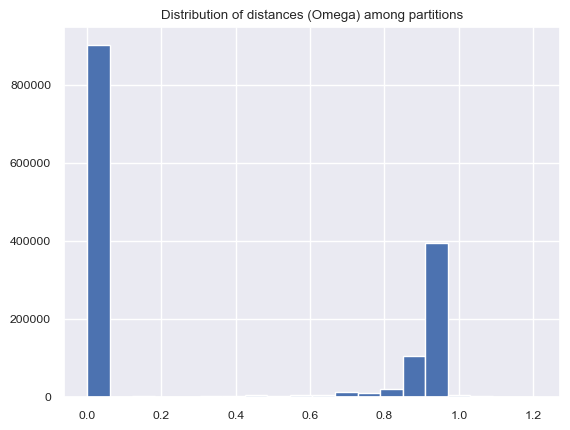

In [34]:
plt.hist(np.tril(partitions_distance_df).flatten(), bins=20)
plt.title("Distribution of distances (Omega) among partitions")
plt.show()

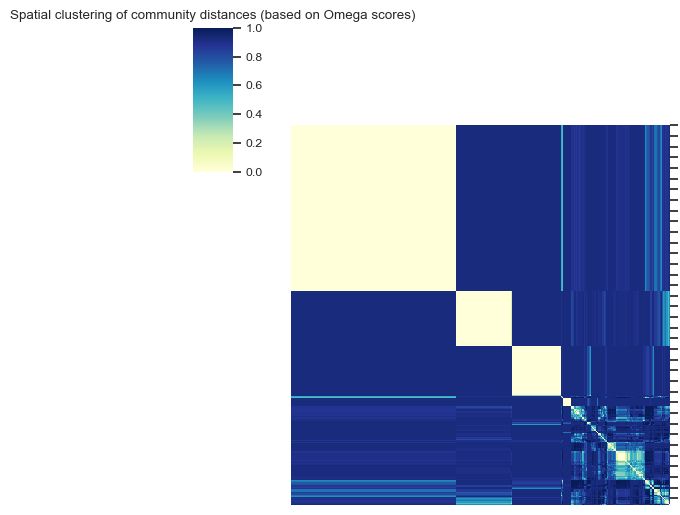

In [35]:
sns.set(font_scale=0.8)
ax = sns.clustermap(partitions_distance_df, cmap='YlGnBu', robust=True, method="average",
                    figsize=(8,8), vmax=1, vmin=0)
ax.ax_row_dendrogram.set_visible(False)
ax.ax_col_dendrogram.set_visible(False)
ax.ax_heatmap.set_xticklabels([])
ax.ax_heatmap.set_yticklabels([])

plt.title("Spatial clustering of community distances (based on Omega scores)")
plt.show()

In [36]:
def plot_2d_embeddings(embeddings_2d=None, title="", distance_df=None, view="matplotlib", partitions_dict=None):

    if embeddings_2d is None:
        mds = MDS(dissimilarity='precomputed', random_state=0)
        embeddings_2d = mds.fit_transform(distance_df)

    if view == "matplotlib":
        #create scatterplot
        plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], alpha=0.3)

    else: # sns
        df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
        df['cluster size'] = [len(partitions_dict[k]) for k in partitions_dict.keys()]
        sns.scatterplot(data=df, x="x", y="y", hue="cluster size", palette="tab10", size="cluster size",
                alpha=0.3, legend='full', sizes=(20, 200))

    #display scatterplot
    plt.title(title)
    plt.grid(False)
    plt.show()

In [37]:
# https://stackabuse.com/guide-to-multidimensional-scaling-in-python-with-scikit-learn/

mds = MDS(dissimilarity='precomputed', random_state=0)
embeddings_2d_partitions = mds.fit_transform(partitions_distance_df)

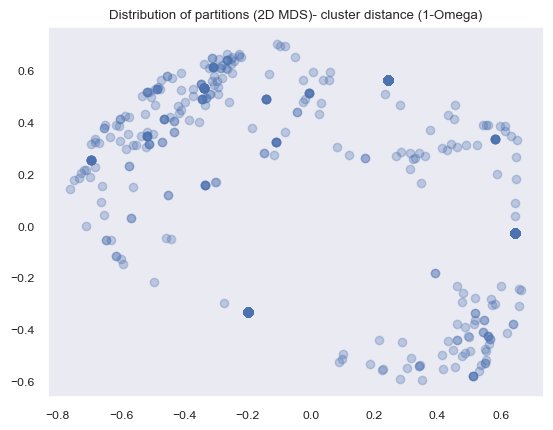

In [38]:
plot_2d_embeddings(embeddings_2d_partitions, title="Distribution of partitions (2D MDS)- cluster distance (1-Omega)")

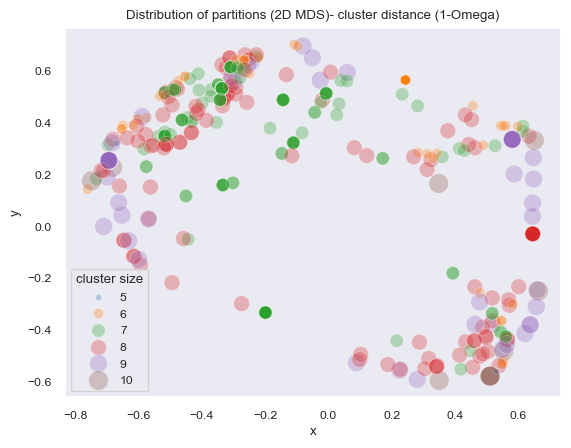

In [39]:
plot_2d_embeddings(embeddings_2d_partitions, title="Distribution of partitions (2D MDS)- cluster distance (1-Omega)",
                   view="sns", partitions_dict=partitions_dict)

In [40]:
# Agglomerative (hierarchical) clustering
def run_agglomerative(df, k, threshold=200, n_pca=None, normalize=False, show_dendogram=False, archstructure=None):

  if normalize:
    sample = StandardScaler().fit_transform(df)
  else:
    sample = df.values

  if n_pca is not None:
    pca = PCA(n_components=n_pca)
    sample_pca = sample # pca.fit_transform(sample)
    # print("Explained PCA variance:", np.sum(pca.explained_variance_ratio_))
    # print("PCA components:",len(pca.explained_variance_ratio_), pca.explained_variance_ratio_)
    model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward',
                                    connectivity=archstructure, distance_threshold=threshold)
    model.fit(sample_pca)
    X = sample_pca
  else:
    # model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward',
    #                                 connectivity=archstructure, distance_threshold=threshold)
    model = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='single',
                                  connectivity=archstructure, distance_threshold=threshold)
    model.fit(sample)
    X = sample
  labels = model.labels_
  print(f"Number of clusters = {1+np.amax(model.labels_)}")

  # Number of clusters in labels, ignoring noise if present.
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)

  #print('clusters:', clustering.labels_)
  fixed_labels = np.where(model.labels_ < 0, 0, model.labels_)

  print("Estimated number of clusters: %d" % n_clusters_)
  print("Estimated number of noise points: %d" % n_noise_)
  classes = set(fixed_labels)
  if len(classes) > 1:
    if n_pca is not None:
      silhouette = metrics.silhouette_score(sample_pca, fixed_labels)
    else:
      silhouette = metrics.silhouette_score(sample, fixed_labels)
  else:
    silhouette = 0.0
  print("Silhouette Coefficient: %0.3f" % silhouette)

  if show_dendogram:
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1, 1, 1)
    dendrogram = sch.dendrogram(sch.linkage(X, method='ward'), ax=ax)
    plt.show()

  return fixed_labels, model, silhouette

In [41]:
# Agglomerative clustering using the distance matrix of partitions
partition_labels, _, silhouette = run_agglomerative(partitions_distance_df, k=4, threshold=None, show_dendogram=False)

classes = set(partition_labels)
print(silhouette, len(classes))

Number of clusters = 4
Estimated number of clusters: 4
Estimated number of noise points: 0
Silhouette Coefficient: -0.041
-0.04086254957223605 4


Number of clusters = 5


Estimated number of clusters: 5
Estimated number of noise points: 0
Silhouette Coefficient: 0.779


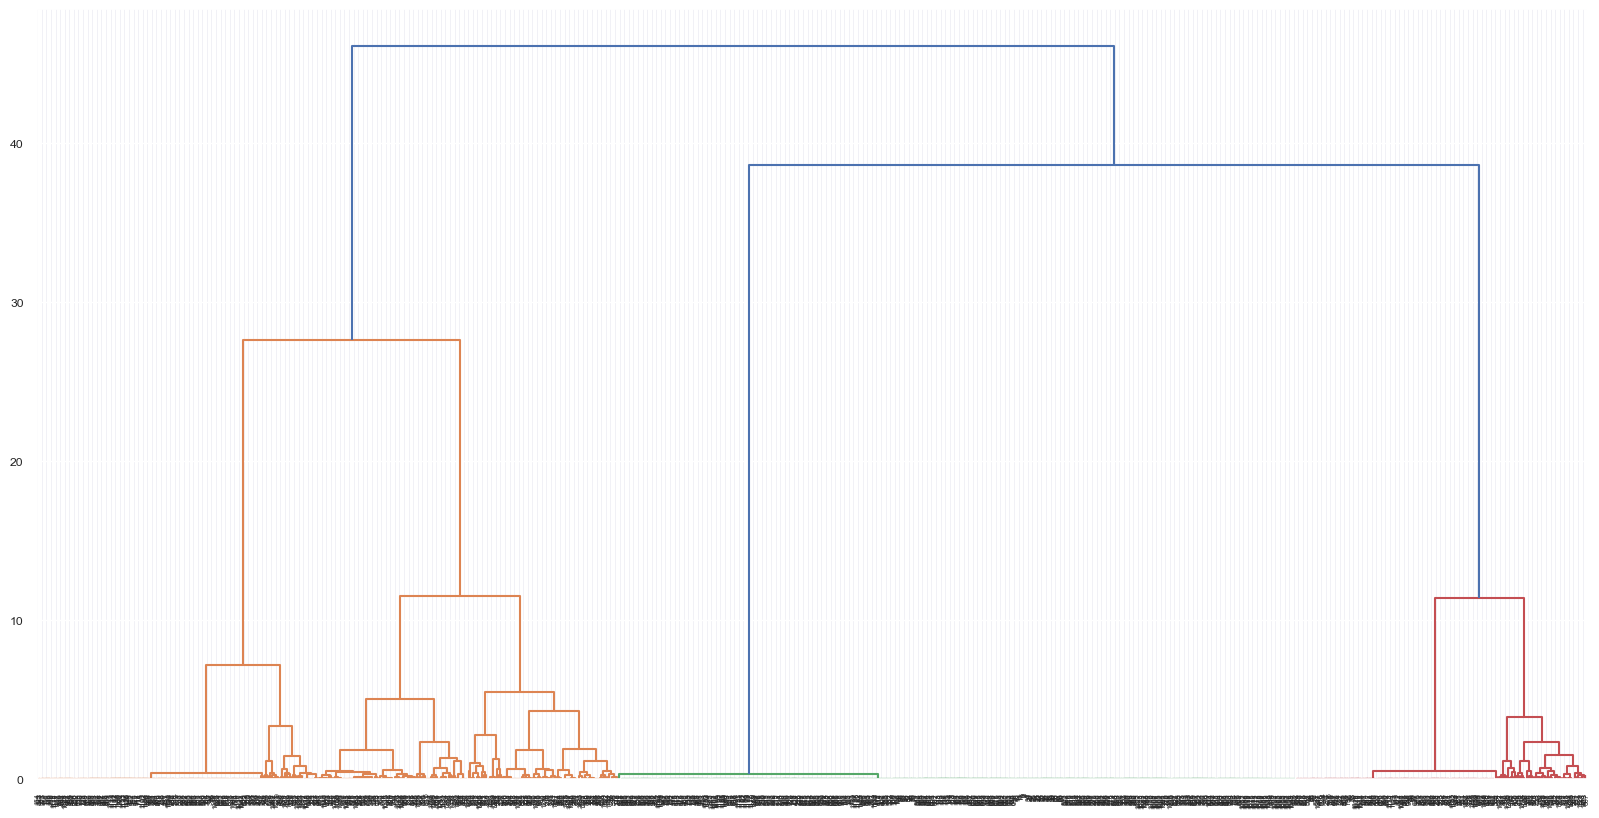

0.7791296285762287 5


In [42]:
# Alternative using agglomerative clustering but on the MDS 2D embeddings
partition_labels_2d, _, silhouette = run_agglomerative(embeddings_2d_partitions, k=5, threshold=None,
                                                       show_dendogram=True, normalize=True, n_pca=2)

classes = set(partition_labels_2d)
print(silhouette, len(classes))

In [43]:
def select_medoids_from_clusters(embeddings_2d, partition_labels, distance_df):
    # Visit each cluster and select a medoid (representative) for each
    classes = set(partition_labels)
    medoids = []
    medoid_labels = []
    for c in classes:
        print("Cluster:", c)
        cluster_indices = [i for i, x in enumerate(partition_labels) if x == c]
        print("   ", len(cluster_indices), "elements")
        # print("Cluster indices:", cluster_indices)
        cluster_distances = []
        for i in cluster_indices:
            cluster_distances.append(np.sum(distance_df.iloc[i, cluster_indices]))
        # print("Cluster distances:", cluster_distances)
        idx = cluster_indices[np.argmin(cluster_distances)]
        print("   medoid:", idx, distance_df.columns[idx])
        medoid_labels.append(distance_df.columns[idx])
        # TODO: Use instead as below
        kmodel = KMedoids(n_clusters=1, method='pam').fit(embeddings_2d[cluster_indices])
        medoids.extend(kmodel.cluster_centers_) # print(kmodel.medoid_indices_)

    return medoids, medoid_labels

In [44]:
coordinates_2d, m_labels = select_medoids_from_clusters(embeddings_2d_partitions, partition_labels_2d, partitions_distance_df)
print(coordinates_2d)
print(m_labels)

Cluster: 0
    228 elements


   medoid: 4 resolution_6_alpha_97_mfuzzy_9_mthreshold_4
Cluster: 1
    220 elements
   medoid: 7 resolution_6_alpha_51_mfuzzy_4_mthreshold_4
Cluster: 2
    529 elements
   medoid: 0 resolution_59_alpha_97_mfuzzy_9_mthreshold_4
Cluster: 3
    118 elements
   medoid: 169 resolution_70_alpha_13_mfuzzy_4_mthreshold_10
Cluster: 4
    117 elements
   medoid: 85 resolution_63_alpha_48_mfuzzy_3_mthreshold_9
[array([ 0.64524839, -0.02875078]), array([0.2432024 , 0.56652374]), array([-0.19929658, -0.33337469]), array([-0.55388509,  0.31424818]), array([-0.29268535,  0.53858534])]
['resolution_6_alpha_97_mfuzzy_9_mthreshold_4', 'resolution_6_alpha_51_mfuzzy_4_mthreshold_4', 'resolution_59_alpha_97_mfuzzy_9_mthreshold_4', 'resolution_70_alpha_13_mfuzzy_4_mthreshold_10', 'resolution_63_alpha_48_mfuzzy_3_mthreshold_9']


In [108]:
def get_xy_coordinates(labels, embeddings_2d, distance_df):
    xy_coordinates = []
    for lb in labels:
        idx = list(distance_df.columns).index(lb)
        #print(idx, lb, embeddings_2d[idx])
        xy_coordinates.append(embeddings_2d[idx])
    #print(medoids)
    return xy_coordinates


def show_clusters(embeddings_2d, partition_labels, medoid_labels=[], distance_df=None, title="",
                  show_labels=False, alpha=0.3, size=(8,8)):

    fig = plt.figure(figsize=size)
    df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
    df['cluster'] = partition_labels
    ax = sns.scatterplot(data=df, x="x", y="y", hue="cluster", palette="tab10", alpha=alpha, legend='full', sizes=(20, 200))
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    if len(medoid_labels) > 0:
        medoids = np.array(get_xy_coordinates(medoid_labels, embeddings_2d, distance_df))
        # print(medoids)
        ax.plot(medoids[:,0], medoids[:,1], 'X', markersize=9, alpha=0.7, color='black')
        # medoids = np.array(coordinates_2d)
        # Annotate the labels
        if show_labels:
            for idx, lb in enumerate(medoid_labels):
                ax.annotate(lb, (medoids[idx,0], medoids[idx,1]))

    plt.grid(False)
    plt.title(title)
    plt.show()

[[ 0.64524839 -0.02875078]
 [ 0.2432024   0.56652374]
 [-0.19929658 -0.33337469]
 [-0.51765838  0.34993002]
 [-0.33711147  0.53436733]]


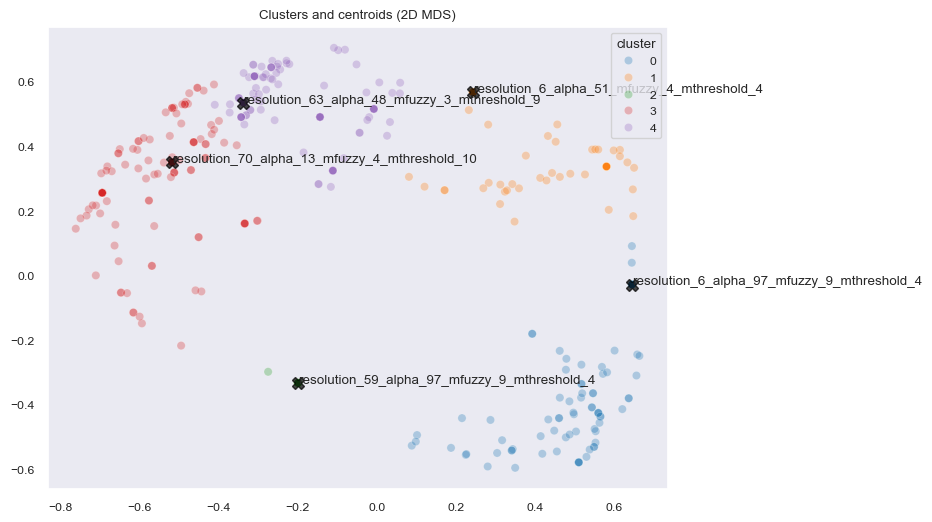

In [54]:
show_clusters(embeddings_2d_partitions, partition_labels_2d, distance_df=partitions_distance_df, size=(8,6),
                            title="Clusters and centroids (2D MDS)", medoid_labels=m_labels, show_labels=True)

335 stable solutions
range: 0.12 0.21875


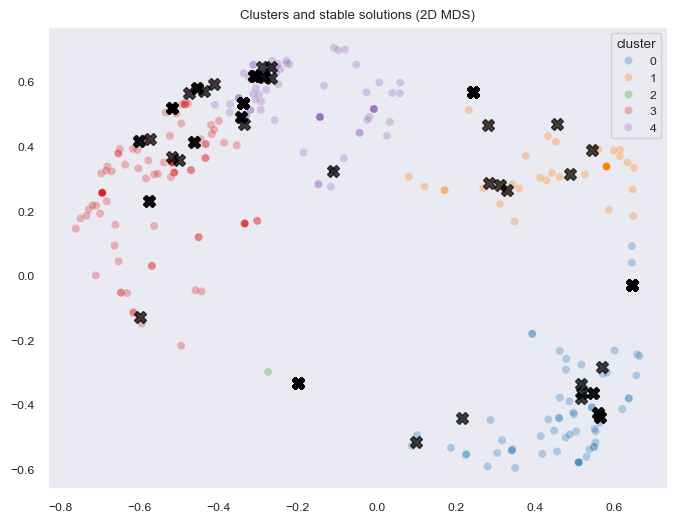

In [176]:
STABLE_SOLUTIONS_FILENAME = "../jpetstore/jpetstore_stable_solutions.pkl"
# STABLE_SOLUTIONS_FILENAME = "../cargo/cargo_stable_solutions.pkl"

other_labels=[]
stable_solutions_dict = None
with open(STABLE_SOLUTIONS_FILENAME, 'rb') as f:
     stable_solutions_dict = pickle.load(f)
     other_labels = stable_solutions_dict.keys()
     print(len(other_labels), "stable solutions")
     values = list(stable_solutions_dict.values())
     print("range:", min(values), max(values))


show_clusters(embeddings_2d_partitions, partition_labels_2d, distance_df=partitions_distance_df, size=(8,6),
                            title="Clusters and stable solutions (2D MDS)", medoid_labels=other_labels, show_labels=False)

Computing parameter distances ...


(1212, 1212)
min-max distances: 0.01010101010101 1.7320508075688772


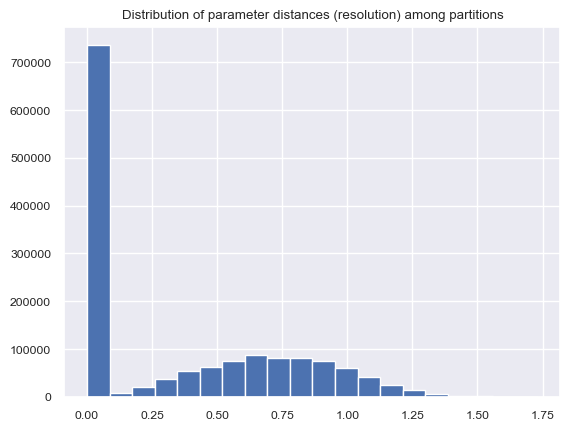

In [49]:
DISTANCE_FILENAME = "../jpetstore/jpetstore_parameter_distances.csv"

print("Computing parameter distances ...")
resolution_distance_df = pd.read_csv(DISTANCE_FILENAME, index_col=0)

print(resolution_distance_df.shape)
resolution_distance_np = np.tril(resolution_distance_df).flatten()
min_non_zero = np.min(resolution_distance_np[np.nonzero(resolution_distance_np)])
print("min-max distances:", min_non_zero, resolution_distance_np.max())

plt.hist(resolution_distance_np, bins=20)
plt.title("Distribution of parameter distances (resolution) among partitions")
plt.show()

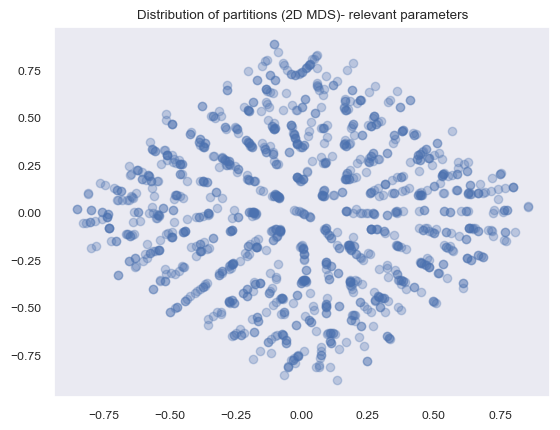

In [50]:
plot_2d_embeddings(title="Distribution of partitions (2D MDS)- relevant parameters", distance_df=resolution_distance_df)
